# Essential dynamics

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from itertools import combinations

import numpy as np
import seaborn as sns

from typing import Iterable
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

sns.set_style("white")

plt.rcParams["figure.dpi"] = 300

In [2]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
models = torch.load(f"../model1.pt", map_location=DEVICE)


In [3]:
def plot_explained_variance(pca, title="Explained Variance", ax: plt.Axes = None):
    num_pca_components = pca.n_components
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(
        range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components]
    )
    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha="center", va="bottom")
    ax.set_title(title)
    ax.set_xlabel("PC")
    ax.set_ylabel("Explained Variance")

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))

In [4]:
def get_output_for_model(model: nn.Module, dataloader: DataLoader):
    model.to(DEVICE)
    logits = []
    with torch.no_grad():
        for xs, ys in dataloader:
            xs, ys = xs.to(model.device), ys.to(model.device)
            outputs = model(xs, ys)
            logits.append(outputs)
    logits = torch.cat(logits).to("cpu")
    return logits


def get_output_for_models(models: Iterable[nn.Module], dataloader: DataLoader):
    outputs = torch.stack([get_output_for_model(model, dataloader) for model in models])
    return outputs.reshape(len(outputs), -1)


def get_pca_components(samples, n_components):
    pca = PCA(n_components=n_components)
    transformed_samples = pca.fit_transform(samples)
    return pca, transformed_samples


def get_form_figure(pca, transformed_samples, figsize=(20, 4)):
    num_pca_components = pca.n_components
    pca_combos = list(combinations(range(num_pca_components), 2))
    num_pca_combos = len(pca_combos)
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=figsize)
    for ax, (first_pca_index, second_pca_index) in zip(axes, pca_combos):
        sns.scatterplot(
            x=transformed_samples[:, first_pca_index],
            y=transformed_samples[:, second_pca_index],
            ax=ax,
            alpha=0.5,
            color="gray",
            s=10,
            legend=False,
        )
        ax.plot(
            transformed_samples[:, first_pca_index],
            transformed_samples[:, second_pca_index],
        )
        ax.set_xlabel(f"PC {first_pca_index+1}")
        ax.set_ylabel(f"PC {second_pca_index+1}")
        ax.set_title(f"PC {second_pca_index+1} vs PC {first_pca_index+1}")
    plot_explained_variance(pca, ax=axes[-1])
    plt.tight_layout(rect=[0, 0, 1, 1])
    return fig

In [5]:
BATCH_SIZE = 1024
dataset = torch.load("ED_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
outputs = get_output_for_models(models, dataloader)


In [6]:
def osculating_circle(curve, t_index):
    # Handle edge cases
    if t_index == 0:
        t_index = 1
    if t_index == len(curve) - 1:
        t_index = len(curve) - 2

    # Central differences for first and second derivatives
    r_prime = (curve[t_index + 1] - curve[t_index - 1]) / 2
    r_double_prime = curve[t_index + 1] - 2 * curve[t_index] + curve[t_index - 1]

    # Append a zero for 3D cross product
    r_prime_3d = np.append(r_prime, [0])
    r_double_prime_3d = np.append(r_double_prime, [0])

    # Curvature calculation and normal vector direction
    cross_product = np.cross(r_prime_3d, r_double_prime_3d)
    curvature = np.linalg.norm(cross_product) / np.linalg.norm(r_prime) ** 3
    signed_curvature = np.sign(cross_product[2])  # Sign of z-component of cross product
    radius_of_curvature = 1 / (curvature + 1e-12)

    # Unit tangent vector
    tangent = r_prime / np.linalg.norm(r_prime)

    # Unit normal vector, direction depends on the sign of the curvature
    if signed_curvature >= 0:
        norm_perp = np.array(
            [-tangent[1], tangent[0]]
        )  # Rotate tangent by 90 degrees counter-clockwise
    else:
        norm_perp = np.array(
            [tangent[1], -tangent[0]]
        )  # Rotate tangent by 90 degrees clockwise

    # Center of the osculating circle
    center = curve[t_index] + radius_of_curvature * norm_perp

    return center, radius_of_curvature


def plot_essential_dynamics_grid(
    samples,
    num_pca_components=3,
    plot_caustic=True,
    figsize=(20, 6),
    num_sharp_points=20,
    num_vertices=35,
    osculate_start=1,
    osculate_end_offset=0,
    osculate_skip=8,
    smoothing_early=10,
    smoothing_late=60,
    smoothing_boundary=200,
):

    CUTOFF_START = osculate_start
    CUTOFF_END = osculate_end_offset
    if len(samples) - CUTOFF_END - CUTOFF_START < 10:
        print("todo warning, less than 10 data points for osculates")

    OSCULATE_SKIP = osculate_skip
    sigma_early = smoothing_early
    sigma_late = smoothing_late
    LATE_BOUNDARY = smoothing_boundary
    START_LERP = 0.2 * LATE_BOUNDARY
    END_LERP = LATE_BOUNDARY

    pca_combos = list(combinations(range(num_pca_components), 2))
    num_pca_combos = len(pca_combos)
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=figsize)
    print("Number of samples: " + str(len(samples)))

    # Make sure we have the smoothed data for each PC
    smoothed_pcs = []
    for pca_component_i in range(0, num_pca_components):
        print(f"Processing smoothing for PC{pca_component_i+1}")
        smoothed_pc = np.copy(samples[:, :1])
        for z in range(len(samples)):
            if z < START_LERP:
                sigma = sigma_early
            elif z > END_LERP:
                sigma = sigma_late
            else:
                sigma = (sigma_late - sigma_early) / (END_LERP - START_LERP) * (
                    z - START_LERP
                ) + sigma_early
            smoothed_pc[z, 0] = gaussian_filter1d(samples[:, pca_component_i], sigma)[z]
        smoothed_pcs.append(smoothed_pc)

    # Make sure we have the osculating data for each pair of PCs
    for ax, (first_pca_index, second_pca_index) in zip(axes, pca_combos):
        # For each PC pair we first do some data processing, then plotting
        print(f"Processing PC{second_pca_index+1} vs PC{first_pca_index+1}")
        smoothed_pc_i = smoothed_pcs[first_pca_index]
        smoothed_pc_j = smoothed_pcs[second_pca_index]
        smoothed_samples = np.column_stack((smoothed_pc_i, smoothed_pc_j))
        osculating_data = {}
        for z in range(CUTOFF_START, len(samples) - CUTOFF_END, 1):
            osculating_data[z] = osculating_circle(smoothed_samples, z)
        radii_list = []
        dcenter_list = []
        dcenter = {}
        radii = {}
        prev_center = None

        for z in range(CUTOFF_START, len(samples) - CUTOFF_END, OSCULATE_SKIP):
            center, radius = osculating_data[z]
            radii[z] = radius
            radii_list.append(radius)
            dcenter[z] = 1000
            if prev_center is not None:
                d = np.linalg.norm(center - prev_center)
                dcenter[z] = d
                dcenter_list.append(d)
            color = "lightgray"
            circle = plt.Circle(
                (center[0].item(), center[1].item()),
                radius.item(),
                alpha=0.5,
                color=color,
                lw=0.5,
                fill=False,
            )
            ax.add_artist(circle)
            prev_center = center

        # Find high curvature points
        radii_list.sort()
        upper_bound = 0
        if len(radii_list) > num_sharp_points:
            upper_bound = radii_list[num_sharp_points]

        # Find caustic cusps
        dcenter_list.sort()
        dcenter_bound = 0
        if len(dcenter_list) > num_vertices:
            dcenter_bound = dcenter_list[num_vertices]

        # Plot un-smoothed points in the background
        ax.scatter(
            x=samples[CUTOFF_START:-CUTOFF_END, first_pca_index],
            y=samples[CUTOFF_START:-CUTOFF_END, second_pca_index],
            alpha=0.8,
            color="lightgray",
            s=10,
        )
        ax.plot(
            samples[CUTOFF_START:-CUTOFF_END, first_pca_index],
            samples[CUTOFF_START:-CUTOFF_END, second_pca_index],
        )
        ax.scatter(
            x=smoothed_samples[CUTOFF_START:-CUTOFF_END, 0],
            y=smoothed_samples[CUTOFF_START:-CUTOFF_END, 1],
            alpha=0.8,
            color="orange",
            s=10,
        )

        for z in range(CUTOFF_START, len(samples) - CUTOFF_END, OSCULATE_SKIP):
            if (
                z > 2 * OSCULATE_SKIP
                and dcenter[z] < dcenter_bound
                and dcenter[z - OSCULATE_SKIP] < dcenter_bound
            ):
                print(f"Vertex [{z}] rate of change of osculate center {dcenter[z]}")
                ax.scatter(smoothed_samples[z, 0], smoothed_samples[z, 1], color="gold")

        # Mark in red high curvature points
        for z in range(CUTOFF_START, len(samples) - CUTOFF_END, OSCULATE_SKIP):
            if radii[z] < upper_bound:
                print(f"Sharp point [{z}] curvature {radii[z]}")
                ax.scatter(smoothed_samples[z, 0], smoothed_samples[z, 1], color="red")
        current_x_limits = ax.get_xlim()
        current_y_limits = ax.get_ylim()

        # Draw the evolute
        if plot_caustic:
            for z in range(CUTOFF_START, len(samples) - CUTOFF_END, 1):
                center, radius = osculating_data[z]

                if (
                    center[0].item() > current_x_limits[0]
                    and center[0].item() < current_x_limits[1]
                ):
                    if (
                        center[1].item() > current_y_limits[0]
                        and center[1].item() < current_y_limits[1]
                    ):
                        ax.scatter(
                            [center[0].item()],
                            [center[1].item()],
                            color="black",
                            s=0.2,
                        )
        ax.set_xlabel(f"PC {first_pca_index+1}")
        ax.set_ylabel(f"PC {second_pca_index+1}")
    axes[0].set_ylabel(f"\n\nPC 1")
    plt.tight_layout(rect=[0, 0, 1, 1])
    fig.set_facecolor("white")
    return fig

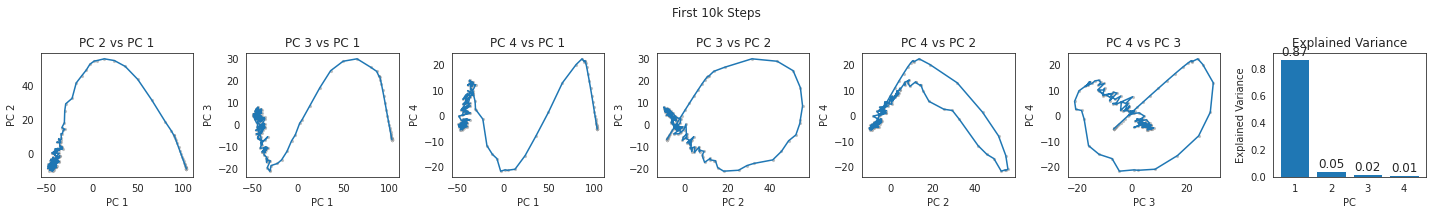

Number of samples: 190
Processing smoothing for PC1
Processing smoothing for PC2
Processing smoothing for PC3
Processing PC2 vs PC1
Processing PC3 vs PC1
Processing PC3 vs PC2


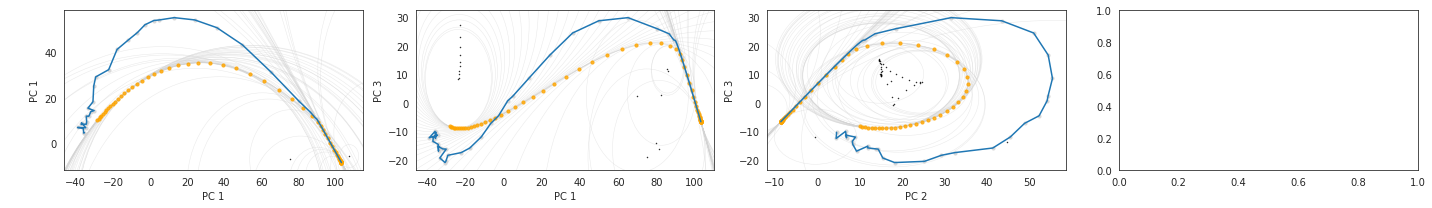

In [7]:
_all_outputs = outputs

pca, transformed_samples = get_pca_components(_all_outputs, n_components=4)
fig = get_form_figure(pca, transformed_samples, figsize=(20, 3))
fig.suptitle("First 10k Steps")
plt.tight_layout()
plt.show()

# pca, transformed_samples = get_pca_components(_all_outputs, n_components=2)
# fig = get_form_figure(pca, transformed_samples, figsize=(20, 4))
# fig.suptitle("All Steps")
# plt.tight_layout()
# plt.show()

fig = plot_essential_dynamics_grid(
    transformed_samples,
    num_pca_components=3,
    plot_caustic=True,
    figsize=(20, 3),
    num_sharp_points=0,
    num_vertices=0,
    osculate_start=15,
    osculate_end_offset=110,
    osculate_skip=1,
    smoothing_early=1,
    smoothing_late=60,
    smoothing_boundary=200,
)
plt.tight_layout()
plt.show()